# [Exploration 11] 뉴스 요약봇 만들기
## 프로젝트 설명 
---
뉴스 기사 원문과 뉴스 제목으로 구성된 데이터셋을 이용해 원문에서 제목을 추출하는 뉴스 요약봇을 설계한다.


## 프로젝트 정리     
---        
1. 데이터 불러오기
2. 데이터 전처리
    - 불용어 처리
    - 정규화 작업
    - 데이터 분포 확인 후 최대 길이 설정
    - 토큰 추가
    - 단어 사전 생성
    - 정수 인코딩 (단어 사전 사용)
    - 빈도수를 기준으로 데이터 처리 (단어 사전 사용) 
3. 모델 설계
    - encoder : 뉴스 기사 원문
    - decoder : 뉴스 제목 
4. 결과 평가
    - 뉴스 기사 원문만 처리하는 encoder-decoder 모델을 설계
    - 원문만으로 뉴스 제목을 예측
    - 예측한 뉴스 제목과 실제 뉴스 제목을 비교
5. 추출적 요약 진행


## 프로젝트 목표
---
- lstm, seq2seq, attention 메커니즘을 이해한다.
- 데이터 전처리 과정을 이해한다.
- 추상적 요약(Abstractive Summarization)과 추출적 요약(Extractive Summarization)의 차이점을 이해한다. 


## 01. load data
- 뉴스기사 데이터(newssummarymore.csv)사용 : [링크](https://github.com/sunnysai12345/News_Summary)

In [ ]:
# 전처리 후 csv 파일 저장

data.to_csv('news_summary_more_after_preprocessing.csv')
# 전처리 끝난 csv파일 불러오기

data = pd.read_csv('news_summary_more_after_preprocessing.csv', encoding='iso-8859-1')

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
data.sample(10)

,headlines,text
8223,Video: Ranveer Singh turns DJ at his 2nd Mumba...,A video shows Ranveer Singh turning DJ at his ...
67906,Ryanair given deadline to give 4L flyers alter...,The UK Civil Aviation Authority (CAA) has orde...
87567,1st Star Wars film made for $11 million earned...,The first Star Wars film 'Star Wars: Episode I...
73343,Haryana Dy Advocate Gen sacked for carrying Ra...,Haryana's Deputy Advocate General Gurdass Sing...
95320,Bihar's model of Grand Alliance can defeat BJP...,Bihar Chief Minister Nitish Kumar on Monday sa...
88433,Google announces Android version for 1 GB RAM ...,Technology major Google on Wednesday announced...
51636,Mumbai Police to have 8-hour duty schedule for...,The Mumbai Police will be switching to an eigh...
70365,Hospital operation theatre's roof collapses tw...,The roof of an operation theatre of Karnataka'...
54850,School van driver held for molesting Class 8 s...,A 32-year-old school van driver was arrested o...
81308,Man who wrote book on surviving bulls trampled...,An American man who was trampled by a bull in ...


## 02. 데이터 전처리
- 중복샘플, NULL 처리

In [5]:
print('전체 data 길이 :', len(data))
print('unique한 headline 수:', data.headlines.nunique())
print('unique한 text 수:', data.text.nunique())

전체 data 길이 : 98401
unique한 headline 수: 98280
unique한 text 수: 98360


- text를 기준으로 중복데이터를 제거

In [6]:
data.drop_duplicates(subset=['text'], inplace = True)
print('전체 data 길이 :', len(data))
print('unique한 headline 수:', data.headlines.nunique())

전체 data 길이 : 98360
unique한 headline 수: 98262


- null 확인 : 없음!

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- text normalization(텍스트 정규화)
    - it'll == it will : 문법을 통일화해준다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
Text         0
Summary      0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


- 불용어, 정규화 처리 후 분포 확인
- 데이터의 길이를 정하는 단계

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


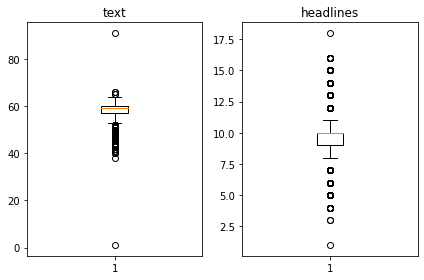

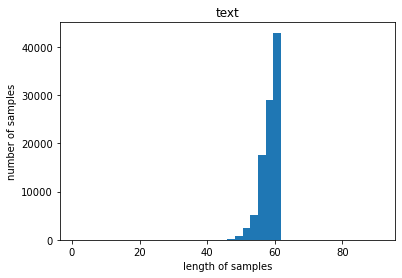

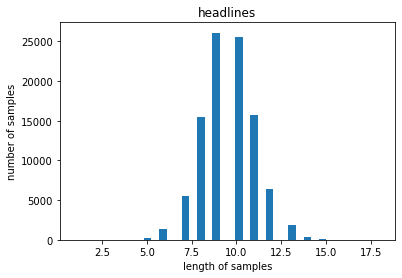

In [16]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1, 2, 2)
plt.boxplot(headline_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text의 경우 50-60 사이의 데이터가 많다. : 65 이하로 자른다. 
- headlines은 14로 잘라주도록 한다. 

In [17]:
text_max_len = 60
headline_max_len = 12

- max_len이 합리적인지 확인하기

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len, data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


- text에서는 0.03%, headlines에서는 2.4%정도의 데이터를 버리게 됩니다.
- 

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플 수:', len(data))

전체 샘플 수: 95838


- 디코더에서 문장의 시작과 끝을 알 수 있도록 각 문장에 **시작토큰, 종료토큰**을 추가합니다.

In [21]:
data['decoder_input']=data['headlines'].apply(lambda x:'sostoken '+x)
data['decoder_target']=data['headlines'].apply(lambda x:x+' eostoken')
data.head()

,headlines,text,Text,Summary,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


- 인코더의 입력 : data\['text'\]
- 디코더의 입력 : data\['decoder_input'\]
- 디코더의 레이블 : data\['decoder_target'\]   


- 모두 numpy타입으로 저장한다. 

In [22]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

- 데이터의 순서를 섞어줍니다.
- 정수 시퀀스 이용

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[92791 46382 78951 ... 12188  8292 21252]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### [코드이해] np.random.shuffle 
- shuffle parameter 조건 : **xndarray or MutableSequence**
- indices가 배열의 크기보다 작을 경우엔? : index외의 데이터는 삭제된다. 
- indices가 배열의 크기보다 큰 경우엔? : 에러 발생 

In [143]:
indices = np.arange(3)
np.random.shuffle(indices)
print(indices)

[0 1 2]


In [144]:
abc = [10, 20, 30, 40, 50]
abc = np.array(abc)

In [145]:
abc = abc[indices]
abc

array([10, 20, 30])

- 전체 데이터 크기를 이용해 전체 데이터를 **훈련, 테스트**로 나눈다.

In [25]:
print('훈련 데이터의 개수:', len(encoder_input))
print('훈련 레이블의 개수:', len(decoder_input))

훈련 데이터의 개수: 95838
훈련 레이블의 개수: 95838


In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


- n_of_val : sklearn 함수 중 train_test_split에서 사용되는 test_size와 같은 역할

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


In [32]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

## 03. 정수 인코딩
- 생성된 단어 사전 확인
    - 각 단어별 빈도수에 따라 정수를 1부터 부여합니다. 

In [33]:
src_tokenizer.word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'in': 4,
 'of': 5,
 'and': 6,
 'on': 7,
 'has': 8,
 'for': 9,
 'said': 10,
 'that': 11,
 'was': 12,
 'is': 13,
 'he': 14,
 'by': 15,
 'with': 16,
 'his': 17,
 'from': 18,
 'after': 19,
 'as': 20,
 'it': 21,
 'at': 22,
 'will': 23,
 'an': 24,
 'be': 25,
 'have': 26,
 'had': 27,
 'who': 28,
 'which': 29,
 'been': 30,
 'year': 31,
 'added': 32,
 'her': 33,
 'were': 34,
 'over': 35,
 'its': 36,
 'this': 37,
 'not': 38,
 'india': 39,
 'also': 40,
 'us': 41,
 'are': 42,
 'she': 43,
 'their': 44,
 'i': 45,
 'while': 46,
 'against': 47,
 'first': 48,
 'police': 49,
 'about': 50,
 'government': 51,
 'people': 52,
 'indian': 53,
 'two': 54,
 'old': 55,
 'they': 56,
 'crore': 57,
 'minister': 58,
 'president': 59,
 'film': 60,
 'him': 61,
 'one': 62,
 'further': 63,
 'during': 64,
 '000': 65,
 'up': 66,
 'court': 67,
 'when': 68,
 'reportedly': 69,
 'all': 70,
 'state': 71,
 'new': 72,
 'years': 73,
 'out': 74,
 'being': 75,
 'former': 76,
 'would': 77,
 'time': 78,

In [37]:
threshold = 7  # 빈도의 기준
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0   # threshold보다 작은 빈도를 가진 단어의 개수
total_freq = 0 # 전체 단어의 빈도수 총 합
rare_freq = 0
                  # (단어, 단어의 빈도수)
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(voacabulary)의 크기:', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt-rare_cnt))
print('단어 집합에서 희귀 단어의 비율:',(rare_cnt/total_cnt)*100)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq/total_freq)*100)

단어 집합(voacabulary)의 크기: 90276
등장 빈도가 6번 이하인 희귀 단어의 수: 65840
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24436
단어 집합에서 희귀 단어의 비율: 72.93189773583234
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7811735138424893


In [43]:
type(src_tokenizer)

keras_preprocessing.text.Tokenizer

In [42]:
type(src_tokenizer.word_index)

dict

In [41]:
type(src_tokenizer.word_counts)

collections.OrderedDict

**전체 등장 빈도에서 희귀 단어가 등장하는 빈도가 2.78% 정도이기 때문에, 빈도가 6회 이하인 단어를 제거합니다.**

In [39]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합 크기에 제한을 둔다.
src_tokenizer.fit_on_texts(encoder_input_train)

In [40]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))

# src_tokenizer 에서 생성한 정수로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 출력
print(encoder_input_train[:3])
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
[[135, 693, 5, 8769, 974, 5482, 7677, 506, 1, 60, 1697, 14333, 4973, 46, 789, 111, 2, 225, 974, 8367, 3, 2569, 620, 202, 695, 68, 43, 13, 2226, 56, 3587, 665, 1188, 479, 4, 161, 5932, 10, 56, 77, 310, 1, 60, 7, 512, 282, 20, 1, 2687, 281, 558, 21, 285, 169, 3374], [455, 22, 3, 1222, 4, 3357, 94, 59, 287, 247, 2811, 2, 110, 190, 126, 6, 139, 61, 2, 759, 372, 262, 14, 345, 38, 26, 545, 78, 247, 32, 130, 42, 54, 5535, 5, 2767, 62, 11, 2465, 324, 1, 2101, 2, 1, 3053, 6, 245, 29, 2101, 2, 1, 1364, 1440], [24, 196, 67, 8, 572, 4552, 617, 6692, 11417, 2, 377, 1, 423, 51, 3311, 5, 4811, 4, 953, 3732, 19, 17336, 9555, 1, 794, 35, 36, 10920, 8770, 1663, 4, 1193, 367, 11, 5583, 790, 25, 898, 4, 7678, 16, 9708, 546, 5811, 172, 6692, 11417, 796, 2, 15384, 1, 1663, 79, 405, 1, 146, 4, 381, 523]]
훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671


- 정수 시퀀스로 변환 후, 확인 결과 문장이 줄어들지 않고 잘 변환된 것을 확인할 수 있었다.
- headlines 데이터 정수 시퀀스로 변환하기

In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


In [45]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) 
rare_cnt = 0 
total_freq = 0 
rare_freq = 0 


for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40460
등장 빈도가 6번 이하인 희귀 단어의 수: 30291
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10169
단어 집합에서 희귀 단어의 비율: 74.86653484923382
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.022192618019075


In [46]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3026, 207, 947, 62, 1562, 1250, 46, 782, 869], [1, 788, 491, 1318, 176, 2260, 58, 59, 90, 3, 23, 48], [1, 3160, 191, 3, 161, 348, 24, 4543, 12, 7159, 69], [1, 166, 75, 4841, 3, 390, 1664, 5, 9343], [1, 328, 146, 1304, 1771, 3, 5183]]
target
decoder  [[3026, 207, 947, 62, 1562, 1250, 46, 782, 869, 2], [788, 491, 1318, 176, 2260, 58, 59, 90, 3, 23, 48, 2], [3160, 191, 3, 161, 348, 24, 4543, 12, 7159, 69, 2], [166, 75, 4841, 3, 390, 1664, 5, 9343, 2], [328, 146, 1304, 1771, 3, 5183, 2]]


- headlines은 문장이 짧기 때문에 빈도수가 낮은 단어가 삭제되면서 길이가 0일 수도 있습니다.
- decoder_input은 시작 토큰과 종료 토큰이 있습니다.
- 때문에 빈도수가 낮으면, 토큰만 남아 문장 길이가 1입니다.
- 1인 문장을 삭제합니다.

In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


/home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


- 이전에 문장 길이 분포를 확인해 text, headlines의 최대 길이를 정했습니다.
- 정한 최대 길이를 기준으로 padding작업을 합니다.

In [49]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

## 04. 모델 설계
- 함수형 API를 이용해 인코더 설계
- 각 단어의 가중치를 더하는 attention 메커니즘을 사용

In [50]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [51]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [53]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [54]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [55]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 20)

Epoch 1/20
300/300 [==============================] - 141s 470ms/step - loss: 5.7982 - val_loss: 5.4193
Epoch 2/20
300/300 [==============================] - 142s 473ms/step - loss: 5.2403 - val_loss: 5.0092
Epoch 3/20
300/300 [==============================] - 142s 473ms/step - loss: 4.8769 - val_loss: 4.7149
Epoch 4/20
300/300 [==============================] - 142s 474ms/step - loss: 4.5991 - val_loss: 4.4922
Epoch 5/20
300/300 [==============================] - 144s 479ms/step - loss: 4.3709 - val_loss: 4.3424
Epoch 6/20
300/300 [==============================] - 144s 480ms/step - loss: 4.1868 - val_loss: 4.2041
Epoch 7/20
300/300 [==============================] - 142s 474ms/step - loss: 4.0282 - val_loss: 4.1072
Epoch 8/20
300/300 [==============================] - 142s 472ms/step - loss: 3.8941 - val_loss: 4.0232
Epoch 9/20
300/300 [==============================] - 141s 471ms/step - loss: 3.7711 - val_loss: 3.9529
Epoch 10/20
300/300 [==============================] - 141s 472m

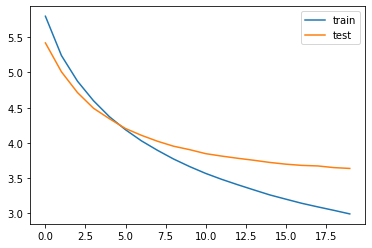

In [56]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 05. 결과 평가하기
- 정수 인덱스 행렬을 실제 데이터로 복원한다.
- 학습 시와 다른 점 : 정답 데이터가 없다. (원본 데이터와 비교하기 때문에)

In [57]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [58]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [59]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [63]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

- 결과를 확인할 수 있는 함수를 생성합니다.

In [64]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [65]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : alleging that the income tax department carried out a raid at his sister's hospital in haryana's rewari swaraj india leader yogendra yadav on wednesday said modiji you can't silence me in a tweet he claimed that the raid was the government's attempt to intimidate him he said this happened because he launched an agitation seeking better prices for farmers' crops 
실제 요약 : can't silence me on tax raid at sister's hospital 
예측 요약 :  i don't know you don't know you akhilesh on note ban


원문 : passengers onboard rajdhani and shatabdi trains can pre order from food outlets like domino's mcdonald's and directly to their seat starting thursday mandatory meals have become optional although passengers must book their meals at irctc co in two hours in advance the eatery will ensure the order is delivered to the passenger when the train at stations 
실제 요약 : railways starts delivering domino's mcdonald's on trains 
예측 요약 :  passengers to get food food at mumbai airport


원문 : the only good thin

예측 요약 :  indian test tests nasa flight tests


원문 : muslim parents of an adopted hindu in dehradun have married him according to hindu customs instead of islamic rituals the family which adopted the boy when he was 12 years old raised him as a hindu and he said he grew up celebrating all the hindu festivals my family has loved me and supported me in everything he added 
실제 요약 : muslim parents get adopted hindu son married in his customs 
예측 요약 :  muslim women hindu muslim muslim muslim muslim muslim muslim family


원문 : riteish deshmukh and his wife genelia d'souza will reunite onscreen after four years for a song in upcoming marathi film confirming the news riteish said i've actually forced her to do the number it felt so good to dance together after four years they were last seen together in a song from his debut marathi film 
실제 요약 : riteish to reunite onscreen after 4 years for a song 
예측 요약 :  abhishek to play in his debut film reports


원문 : sidelined bjp mp shatrughan sinha on s

예측 요약 :  australia match due to eng wc due to wc


원문 : former cricketer virender sehwag has claimed that ex india captain sourav ganguly's sacrifice of his batting spot to give ms dhoni a chance to bat higher up the order was one of the reasons behind the latter's success speaking about ganguly's tendency to experiment with the batting order sehwag said ganguly always believed in giving chances to new players 
실제 요약 : ganguly's sacrifice reason behind dhoni's success sehwag 
예측 요약 :  dhoni is a innings in a innings sehwag


원문 : facing a 13 5 million lawsuit by a us state attorney general for not disclosing the 2016 data breach within a reasonable time frame hackers had stolen the first names last names and license numbers of at least 13 500 uber drivers in the state of pennsylvania the attorney general may seek fine of up to 1 000 per violation 
실제 요약 : uber faces 13 5 million lawsuit over stolen data of drivers 
예측 요약 :  us firm sued for stealing data on data breach


원문 : the us se

- 실제 요약본과 문장의 길이는 비슷하지만, 동일한 단어가 반복되는 문제가 있다.   


## 06. 추출적 요약
- 추출적 요약이란 본문에 있는 문장을 그대로 가져와 요약하는 방법입니다.
- summa 패키지를 이용하면 summarize 모듈을 사용할 수 있습니다.
- 모듈 사용법
    - 리스트로 이루어진 여러 문장은 동작하지 않음

In [77]:
import requests
from summa.summarizer import summarize

In [106]:
text_str = data['text'][200]
print(summarize(text_str, ratio=0.5))

Australia's wicketkeeper-batswoman Alyssa Healy has said that the Australian team needs to be wary of India's women's T20I team captain Harmanpreet Kaur at the ICC Women's T20 World Cup next year.


In [99]:
text_str = data['text'][100]
print(summarize(text_str, ratio=0.8))

German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital.


In [98]:
text_str = data['text'][50]
print(summarize(text_str, ratio=0.8))

Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).
This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.


Step 1. 데이터 수집하기

Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

# 루브릭 평가
---
1. **Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.**   


2. **텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.**  
    
     
3. **Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.** 
   

    
# 회고
---
## 어려웠던 점 
- 평가
    - 영어로 된 기사의 요약을 직접 읽어서 평가하는 방법이 어려웠다.
    
## 알게된 점 
- attention
    - 노드의 가중치를 적용하는 attention을 직접 구성하고 동작시켜보았다.
- np.random.shuffle
    - numpy array의 순서를 indicies로 섞는 코드를 뜯어보면서 익힐 수 있었다.\
- tokenizer의 데이터타입
    - tokenizer의 여러 속성의 데이터 타입을 직접 확인하였다. 
    
## 더 공부할 점
- 요약 평가 지표 적용
    - 직접 읽어서 확인하는 것이 아닌 정량적인 평가 지표가 있다고 한다. 이를 직접 적용시켜보고 싶다.

## 다짐
- 개념에 대해 파악하고 궁금한 점을 찾아보느라, 시간이 늦어져 학습을 여러 번 해보지 못한 점이 아쉽다. 더 효율적으로 프로젝트를 진행하는 방법을 익혀야겠다. 코드에 대해 공식 다큐먼트로도 이해가 가지 않을 때에는 작은 데이터셋을 직접 만들어 실험해보면서 문법을 공부할 수 있었다.